# Developing custom gradient and multiple shooting method for full ephemeris transition

In [350]:
import numpy as np
from scipy.linalg import block_diag
import spiceypy as spice
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
from pprint import pprint
import copy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [443]:
import sys 
sys.path.append("../")
import luna2

In [444]:
def print_matrix(mat, max_digit=7):
    nrow,ncol = mat.shape
    for i in range(nrow):
        row_str = ""
        for j in range(ncol):
            num_str = f"{mat[i,j]: 1.2e}"
            row_str += " "*(max_digit - len(num_str)) + num_str + " "
        print(row_str)
    return

In [445]:
spice.furnsh(os.path.join(os.getenv("SPICE"), "lsk", "naif0012.tls"))
spice.furnsh(os.path.join(os.getenv("SPICE"), "spk", "de440.bsp"))
spice.furnsh(os.path.join(os.getenv("SPICE"), "pck", "gm_de440.tpc"))

spice.furnsh(os.path.join("..", "assets", "spice", "earth_moon_rotating_mc.tf"))  # custom frame kernel

In [446]:
# seed halo in CR3BP
mu_cr3bp = 1.215058560962404E-2
lstar = 389703.0
tstar = 382981.0
vstar = lstar/tstar

# ID723 in southern halo
x0_cr3bp = np.array([
    1.0134037728554581E+0, 0, -1.7536227281091840E-1,
    0, -8.3688427472776439E-2, 0
])
period = 1.3960732332950263E+0

In [447]:
# create CR3BP propagator & propagate over one period
prop_cr3bp = luna2.PropagatorCR3BP(mu_cr3bp)
#t_eval = np.linspace(0,period,500)   
t_eval = [0, period/2, period, 1.5*period, 2*period]
res_cr3bp = prop_cr3bp.solve(
    [0,t_eval[-1]], x0_cr3bp, t_eval=t_eval, dense_output=True
)
states_cr3bp_MC = luna2.canonical_to_dimensional(
    luna2.shift_barycenter_to_m2(res_cr3bp.y, mu_cr3bp),
    lstar, 
    vstar
)

In [476]:
# transform to propagator's frame
naif_frame = "ECLIPJ2000"
et0 = spice.utc2et("2025-12-18T12:28:28")
epochs = et0 + res_cr3bp.t*tstar
states_J2000 = luna2.apply_frame_transformation(
    epochs,
    states_cr3bp_MC,
    "EARTHMOONROTATINGMC",
    naif_frame
)

# create N-body propagator
print("Creating N-body integrator...")
lstar_nbody = 3000.0
naif_ids = ["301", "399", "10"]
mus = [spice.bodvrd(ID, "GM", 1)[1][0] for ID in naif_ids]
et0 = spice.utc2et("2025-12-18T12:28:28")

prop_nbody = luna2.PropagatorNBody(
    naif_frame,
    naif_ids, 
    mus,
    lstar_nbody,
    use_canonical=True,
)
tf_nbody = res_cr3bp.t[-1]*tstar/prop_nbody.tstar
states_J2000 = luna2.dimensional_to_canonical(states_J2000, prop_nbody.lstar, prop_nbody.vstar)
prop_nbody.summary()

# integrate
res_nbody = prop_nbody.solve(
    et0,
    [0, tf_nbody],
    states_J2000[:,0],
    t_eval=np.linspace(0,tf_nbody,1000)
)

Creating N-body integrator...
 ******* N-body propagator summary ******* 
 |   NAIF frame      : ECLIPJ2000
 |   NAIF IDs        : ['301', '399', '10']
 |   GMs             : [4902.800118457549, 398600.4355070226, 132712440041.27939]
 |   Canonical units : True
 |   lstar           : 3000.0
 |   tstar           : 2346.711967573276
 |   vstar           : 1.278384412511556
 ----------------------------------------- 


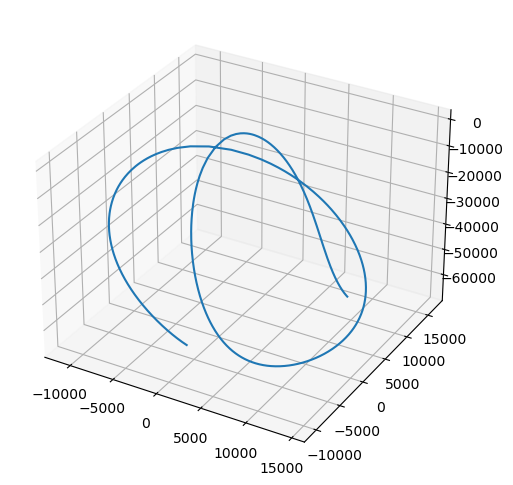

In [477]:
# plot CR3BP trajectory
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection = '3d')
ax.plot(res_nbody.y[0,:]*lstar_nbody,
        res_nbody.y[1,:]*lstar_nbody,
        res_nbody.y[2,:]*lstar_nbody,
    label=f"N-body ({naif_frame} - canonical)")
plt.show()

In [478]:
# Construct nodes for two revolutions
state_half_period = states_J2000[:,1]
nodes = [
    states_J2000[:,0],
    states_J2000[:,1],
    states_J2000[:,2],
    #states_J2000[:,3],
    #states_J2000[:,4],
]
tofs = [period*tstar/prop_nbody.tstar/2 + idx for idx in range(len(nodes)-1)]
tofs_bounds = [
    [tof*0.85, tof*1.15] for tof in tofs
]

# create bounds on et0 and nodes
delta_et0_bounds = [-1000, 1000]
nodes_bounds = [
    luna2.get_node_bounds_relative(states_J2000[:,0], [0.15, 0.05, 0.15, 0.05, 0.15, 0.05]),
    luna2.get_node_bounds_relative(states_J2000[:,1], [0.15, 0.05, 0.15, 0.05, 0.15, 0.05]),
    luna2.get_node_bounds_relative(states_J2000[:,2], [0.15, 0.05, 0.15, 0.05, 0.15, 0.05]),
    #luna2.get_node_bounds_relative(states_J2000[:,3], [0.15, 0.05, 0.15, 0.05, 0.15, 0.05]),
    #luna2.get_node_bounds_relative(states_J2000[:,4], [0.15, 0.05, 0.15, 0.05, 0.15, 0.05]),
]

# create UDP for full-ephemeris transition
udp = luna2.FullEphemerisTransition(
    prop_nbody,
    et0,
    nodes,
    tofs,
    delta_et0_bounds=delta_et0_bounds,
    nodes_bounds=nodes_bounds,
    tofs_bounds=tofs_bounds,
)
lb,ub = udp.get_bounds()

In [479]:
et0

819332977.1835357

In [452]:
# build nominal decision vector to test routines
xtest = (np.array(ub) + np.array(lb))/2
fvec, sol_fwd_list, sol_bck_list = udp.fitness(xtest, True, True)

# test gradient evaluation
grad = udp.gradient(xtest, dx=1e-6, use_h=False)

# unpack decision vector
et_nodes, tofs, nodes = udp.unpack_x(xtest)

Integrating segment 0
Appending inequality 0: [-0.048474746038445815, 0.07620264489230733, 0.07737421083651697, 0.002028484699021338, -0.002796451676366936, 0.006286352233888182]
Appending inequality 1: [0.022697306071315815, -0.0855122302679514, 0.18140189220028446, 0.00016180163549000745, -0.00045770966498082967, -0.0014275373234634292]


In [453]:
nF = int(6*2) + 1  # 6*2 constraints + objective
nX = int(grad.shape[0]/nF)
grad.shape[0], nF, nX, nF*nX

(273, 13, 21, 273)

In [454]:
svf0, stm0, sol0 = prop_nbody.get_stm_cdm(et_nodes[0], tofs[0]/2, nodes[0], get_svf=True)
svdot0 = prop_nbody.eom(et_nodes[0], tofs[0]/2, svf0)
#svdot0 = prop_nbody.eom(et_nodes[0], 0, nodes[0])

print_matrix(-stm0)

-8.23e-01 -3.34e-02 -3.93e-02 -5.33e+01 -5.43e-01 -9.39e-01 
-3.35e-02 -9.35e-01 -5.32e-02 -5.43e-01 -5.56e+01 -1.00e+00 
-3.81e-02 -5.40e-02 -1.26e+00 -9.25e-01 -1.01e+00 -6.22e+01 
 6.50e-03 -9.55e-04 -1.94e-03 -7.92e-01 -2.29e-02 -6.70e-02 
-9.58e-04  2.64e-03 -1.95e-03 -2.29e-02 -9.11e-01 -5.53e-02 
-1.81e-03 -2.04e-03 -1.08e-02 -6.52e-02 -5.64e-02 -1.32e+00 


In [455]:
print_matrix(grad.reshape(nF,nX)[1:,1:][0:6,0:6])

-8.23e-01 -3.34e-02 -3.93e-02 -5.33e+01 -5.43e-01 -9.39e-01 
-3.35e-02 -9.35e-01 -5.32e-02 -5.43e-01 -5.56e+01 -1.00e+00 
-3.81e-02 -5.40e-02 -1.26e+00 -9.25e-01 -1.01e+00 -6.22e+01 
 6.50e-03 -9.55e-04 -1.94e-03 -7.92e-01 -2.29e-02 -6.70e-02 
-9.58e-04  2.64e-03 -1.95e-03 -2.29e-02 -9.11e-01 -5.53e-02 
-1.81e-03 -2.04e-03 -1.08e-02 -6.52e-02 -5.64e-02 -1.32e+00 


In [456]:
svf1, stm1, sol1 = prop_nbody.get_stm_cdm(et_nodes[1], -tofs[0]/2, nodes[1], get_svf=True)
svdot1 = prop_nbody.eom(et_nodes[1], -tofs[0]/2, svf1)
#svdot1 = prop_nbody.eom(et_nodes[1], 0, nodes[1])

print_matrix(stm1)

 3.30e+01  2.26e+01 -2.13e+02 -1.62e+02 -4.79e+01  1.31e+01 
 1.86e+01 -2.18e+01 -6.21e+01 -4.60e+01 -1.65e+01  4.21e+00 
 7.29e+00  6.89e+00 -2.65e+02 -2.02e+02 -6.01e+01 -1.43e+01 
-3.56e-01 -2.55e-01  3.49e+00  2.68e+00  8.06e-01 -4.62e-02 
-2.19e-01  2.32e-01  1.13e+00  8.65e-01  2.54e-01 -2.30e-02 
-3.88e-01 -2.54e-01  7.69e+00  5.85e+00  1.74e+00  2.65e-01 


In [457]:
-(svdot1 - svdot0)

array([-2.02848470e-03,  2.79645168e-03, -6.28635223e-03, -1.41583168e-05,
        4.35268989e-06, -1.91926121e-05])

In [458]:
print_matrix(grad.reshape(nF,nX)[1:,:][:,0:6])

-3.18e-03 -8.23e-01 -3.34e-02 -3.93e-02 -5.33e+01 -5.43e-01 
 3.21e-03 -3.35e-02 -9.35e-01 -5.32e-02 -5.43e-01 -5.56e+01 
 3.73e-04 -3.81e-02 -5.40e-02 -1.26e+00 -9.25e-01 -1.01e+00 
-1.87e-04  6.50e-03 -9.55e-04 -1.94e-03 -7.92e-01 -2.29e-02 
-1.18e-04 -9.58e-04  2.64e-03 -1.95e-03 -2.29e-02 -9.11e-01 
-6.85e-05 -1.81e-03 -2.04e-03 -1.08e-02 -6.52e-02 -5.64e-02 
 1.89e-03  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 
 4.77e-03  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 
 1.25e-03  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 
-2.62e-04  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 
 1.85e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 
-1.69e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 


### Understanding epoch dependence of a state...

In [459]:
svf0

array([-2.99334174e+00, -7.79964968e-01, -1.87101992e+01, -3.55694696e-02,
       -7.65640479e-04,  1.56585638e-01])

In [460]:
h_ptrb = 1e-6
svf0, _, _ = prop_nbody.get_stm_cdm(et_nodes[0], tofs[0]/2, nodes[0], get_svf=True)

# perturbed
svf0_ptrb, _, _ = prop_nbody.get_stm_cdm(et_nodes[0] + h_ptrb*prop_nbody.tstar, tofs[0]/2, nodes[0], get_svf=True)

# forward differencing
print(f"Forward difference: {(svf0_ptrb - svf0)/h_ptrb}")

# evaluate EOM at final time
sv0_dot0 = prop_nbody.eom(et_nodes[0], 0, nodes[0])
svf_dot0 = prop_nbody.eom(et_nodes[0], tofs[0]/2, svf0)
print(f"EOM evaluation dx0/dt: {sv0_dot0}")
print(f"EOM evaluation dxf/dt: {svf_dot0}")

Forward difference: [ 4.04816625e-03 -2.76202172e-04  5.48617152e-04  1.33463303e-04
  1.54219333e-05  2.74304190e-05]
EOM evaluation dx0/dt: [-0.04468183  0.01672482  0.00017905 -0.00010491 -0.000308    0.00252287]
EOM evaluation dxf/dt: [-0.03556947 -0.00076564  0.15658564  0.00051933 -0.00021478  0.00329393]


In [461]:
A = -(svdot1 - svdot0)
B = np.concatenate((-stm0,stm1), axis=1)
C = svdot1*(-1/2) - svdot0*(1/2)

In [462]:
print_matrix(np.concatenate((A.reshape(-1,1),B,C.reshape(-1,1)), axis=1), max_digit=7)

-2.03e-03 -8.23e-01 -3.34e-02 -3.93e-02 -5.33e+01 -5.43e-01 -9.39e-01  3.30e+01  2.26e+01 -2.13e+02 -1.62e+02 -4.79e+01  1.31e+01  3.46e-02 
 2.80e-03 -3.35e-02 -9.35e-01 -5.32e-02 -5.43e-01 -5.56e+01 -1.00e+00  1.86e+01 -2.18e+01 -6.21e+01 -4.60e+01 -1.65e+01  4.21e+00  2.16e-03 
-6.29e-03 -3.81e-02 -5.40e-02 -1.26e+00 -9.25e-01 -1.01e+00 -6.22e+01  7.29e+00  6.89e+00 -2.65e+02 -2.02e+02 -6.01e+01 -1.43e+01 -1.60e-01 
-1.42e-05  6.50e-03 -9.55e-04 -1.94e-03 -7.92e-01 -2.29e-02 -6.70e-02 -3.56e-01 -2.55e-01  3.49e+00  2.68e+00  8.06e-01 -4.62e-02 -5.26e-04 
 4.35e-06 -9.58e-04  2.64e-03 -1.95e-03 -2.29e-02 -9.11e-01 -5.53e-02 -2.19e-01  2.32e-01  1.13e+00  8.65e-01  2.54e-01 -2.30e-02  2.17e-04 
-1.92e-05 -1.81e-03 -2.04e-03 -1.08e-02 -6.52e-02 -5.64e-02 -1.32e+00 -3.88e-01 -2.54e-01  7.69e+00  5.85e+00  1.74e+00  2.65e-01 -3.30e-03 


### Concatenate them...

In [463]:
# custom procedure to create gradient
As, Bs_diag, Bs_upperdiag, Cs = [], [], [] ,[]

# for-loop: for each leg
n_legs = len(tofs)
for idx in range(n_legs):
    idx_fwd_seg = idx
    idx_back_seg = idx + 1
    print(f"idx = {idx}, idx_nodes = {idx_fwd_seg} & {idx_back_seg}")
    
    # forward segment
    svf0, stm0, sol0 = prop_nbody.get_stm_cdm(et_nodes[idx_fwd_seg], tofs[idx]/2, nodes[idx_fwd_seg], get_svf=True)
    svdot0 = prop_nbody.eom(et_nodes[0], tofs[idx]/2, svf0)
    
    # backward segment
    svf1, stm1, sol1 = prop_nbody.get_stm_cdm(et_nodes[idx_back_seg], -tofs[idx]/2, nodes[idx_back_seg], get_svf=True)
    svdot1 = prop_nbody.eom(et_nodes[1], -tofs[idx]/2, svf1)
    
    # construct elements of Jacobian
    As.append(-(svdot1 - svdot0))
    Bs_diag.append(-stm0)
    Bs_upperdiag.append(stm1)
    Cs.append(svdot1*(-1/2) - svdot0*(1/2))

idx = 0, idx_nodes = 0 & 1
idx = 1, idx_nodes = 1 & 2


In [464]:
# directly compute sensitivity with respect to et0 & with respect to tofs...
h_ptrb = 1e-6

# w.r.t. et0
xtest_ptrb_fwd = copy.copy(xtest)
xtest_ptrb_fwd[0] += h_ptrb

xtest_ptrb_bck = copy.copy(xtest)
xtest_ptrb_bck[0] -= h_ptrb

A = (np.array(udp.fitness(xtest_ptrb_fwd)) - np.array(udp.fitness(xtest_ptrb_bck)))/(2*h_ptrb)
A = A.reshape(-1,1)

# w.r.t. TOF
C = np.zeros((nF,len(tofs)))
for idx in range(len(tofs)):
    xtest_ptrb_fwd = copy.copy(xtest)
    xtest_ptrb_fwd[1+6*len(nodes)+idx] += h_ptrb

    xtest_ptrb_bck = copy.copy(xtest)
    xtest_ptrb_bck[1+6*len(nodes)+idx] -= h_ptrb
    
    C[:,idx] = (np.array(udp.fitness(xtest_ptrb_fwd)) - np.array(udp.fitness(xtest_ptrb_bck)))/(2*h_ptrb)

In [480]:
# concatenate from each segment
#A = np.concatenate(tuple(As)).reshape(-1,1)

B_diag = np.concatenate((block_diag(*Bs_diag), np.zeros((6*n_legs,6))), axis=1)
B_offdiag = np.concatenate((np.zeros((6*n_legs,6)), block_diag(*Bs_upperdiag)), axis=1)
B = B_diag + B_offdiag

# append zeros row at the top
B = np.concatenate((np.zeros((1,nX-1-len(tofs))),B))
#C = block_diag(*Cs).T
#B.shape

In [492]:
#grad_custom = np.concatenate((A,B,C), axis=1)
grad_custom = udp.gradient_custom(xtest, return_list=False)

In [493]:
grad_custom.shape

(13, 21)

In [494]:
#grad_custom.reshape(np.size(grad_custom),)

In [497]:
%time udp.gradient_custom(xtest, dx=1e-6);

CPU times: user 2.31 s, sys: 0 ns, total: 2.31 s
Wall time: 2.31 s


In [ ]:
%time udp.gradient(xtest, dx=1e-6);

In [ ]:
plt.spy(grad_custom - grad.reshape(nF,nX), precision=1e-6)

In [428]:
#print_matrix(B[:,:6])
print_matrix(grad_custom[:,16:])

 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 
 0.00e+00  0.00e+00  0.00e+00  3.54e-02  0.00e+00 
 0.00e+00  0.00e+00  0.00e+00  5.09e-03  0.00e+00 
 0.00e+00  0.00e+00  0.00e+00 -1.59e-01  0.00e+00 
 0.00e+00  0.00e+00  0.00e+00 -5.80e-04  0.00e+00 
 0.00e+00  0.00e+00  0.00e+00  1.15e-04  0.00e+00 
 0.00e+00  0.00e+00  0.00e+00 -3.34e-03  0.00e+00 
-5.53e+01  1.35e+00  2.23e+00  1.89e-03  1.86e-02 
 1.35e+00 -5.48e+01  4.67e-03  4.77e-03  1.40e-02 
 2.22e+00 -1.18e-02 -6.25e+01  1.25e-03  1.65e-01 
 8.69e-01 -6.63e-02 -1.39e-01 -2.62e-04  4.86e-04 
-6.61e-02  8.50e-01 -9.41e-03  1.85e-05  5.32e-04 
-1.39e-01 -7.30e-03  1.31e+00 -1.69e-05 -3.31e-03 


In [429]:
print_matrix(grad.reshape(nF,nX)[1:,:][:,16:])

 0.00e+00  0.00e+00  0.00e+00  3.54e-02  0.00e+00 
 0.00e+00  0.00e+00  0.00e+00  5.09e-03  0.00e+00 
 0.00e+00  0.00e+00  0.00e+00 -1.59e-01  0.00e+00 
 0.00e+00  0.00e+00  0.00e+00 -5.80e-04  0.00e+00 
 0.00e+00  0.00e+00  0.00e+00  1.15e-04  0.00e+00 
 0.00e+00  0.00e+00  0.00e+00 -3.34e-03  0.00e+00 
-5.53e+01  1.35e+00  2.23e+00  1.89e-03  1.86e-02 
 1.35e+00 -5.48e+01  4.67e-03  4.77e-03  1.40e-02 
 2.22e+00 -1.18e-02 -6.25e+01  1.25e-03  1.65e-01 
 8.69e-01 -6.63e-02 -1.39e-01 -2.62e-04  4.86e-04 
-6.61e-02  8.50e-01 -9.41e-03  1.85e-05  5.32e-04 
-1.39e-01 -7.30e-03  1.31e+00 -1.69e-05 -3.31e-03 


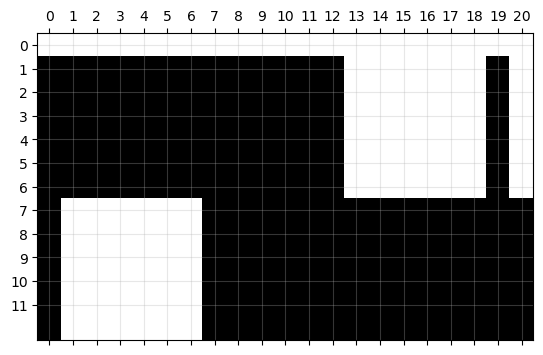

In [430]:
plt.spy(grad_custom)
plt.grid(True, alpha=0.3)
plt.xticks(range(nX))
plt.yticks(range(nF-1))
plt.show()

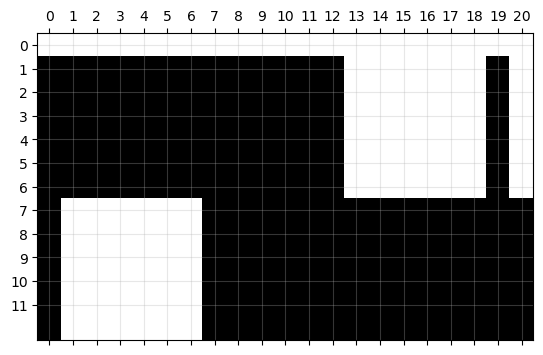

In [431]:
plt.spy(grad.reshape(nF,nX))
plt.grid(True, alpha=0.3)
plt.xticks(range(nX))
plt.yticks(range(nF-1))
plt.show()

In [198]:
#print_matrix(grad.reshape(nF,nX), max_digit=7)

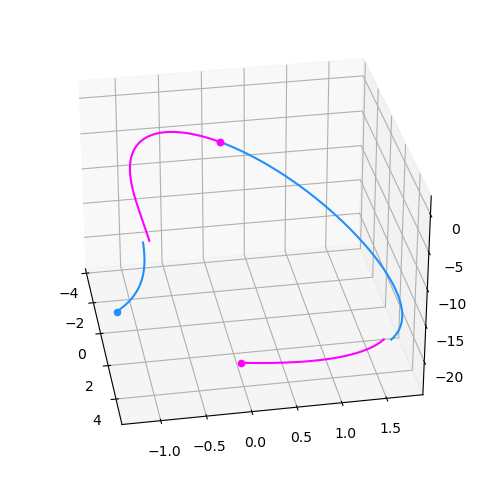

In [208]:
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection = '3d')

for sol0 in sol_fwd_list:
    ax.scatter(sol0.y[0,0], sol0.y[1,0], sol0.y[2,0], marker="o", color="dodgerblue")
    ax.plot(sol0.y[0,:], sol0.y[1,:], sol0.y[2,:], color="dodgerblue")

for sol1 in sol_bck_list:
    ax.scatter(sol1.y[0,0], sol1.y[1,0], sol1.y[2,0], marker="o", color="magenta")
    ax.plot(sol1.y[0,:], sol1.y[1,:], sol1.y[2,:], color="magenta")

ax.view_init(30,-10)
plt.show()